In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
!pip install opencv-python
import cv2
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.optimizers import Adam

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

sns.set_style('darkgrid')

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

In [2]:
def seed_everything(seed=42):
    # Set the seed for Python's built-in random module
    random.seed(seed)
    
    # Set the seed for NumPy's random number generator
    np.random.seed(seed)
    
    # Set the seed for TensorFlow's random number generator
    tf.random.set_seed(seed)
    
    # Set the PYTHONHASHSEED environment variable to ensure reproducibility
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    # Configure TensorFlow to use a single thread for operations
    tf.config.threading.set_intra_op_parallelism_threads(1)
    tf.config.threading.set_inter_op_parallelism_threads(1)
    
    # Enable deterministic operations in TensorFlow
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Call the function to set all seeds
seed_everything()

# Load Data

In [3]:
dataset = 'raw-img'
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)


def convert_path_to_df(dataset):
    image_dir = Path(dataset)

    # Get filepaths and labels
    # filepaths 使用 glob 方法查找目录中的所有图片文件路径，包括 .JPG, .jpg, .jpeg, 和 .PNG 扩展名。
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.PNG'))
    
    # os.path.split(x)[0] 获取每个文件路径的上一级目录（即文件所在的文件夹）。
    # os.path.split(...)[1] 获取该目录名作为标签（假设文件夹名代表图片的类别）
    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    # 将 filepaths 和 labels 列表转换为 Pandas Series，并分别命名为 "Filepath" 和 "Label" 列
    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

image_df = convert_path_to_df(dataset)

# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)


train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)


# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 17983 validated image filenames belonging to 10 classes.
Found 4495 validated image filenames belonging to 10 classes.
Found 5620 validated image filenames belonging to 10 classes.


# Model Evaluation

In [9]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

# Load the pretained model
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB7(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.45)(x)

outputs = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.load_weights("animals_classification_model_checkpoint.weights.h5")

In [10]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.09624
Test Accuracy: 96.98%


# Visualizing loss curves

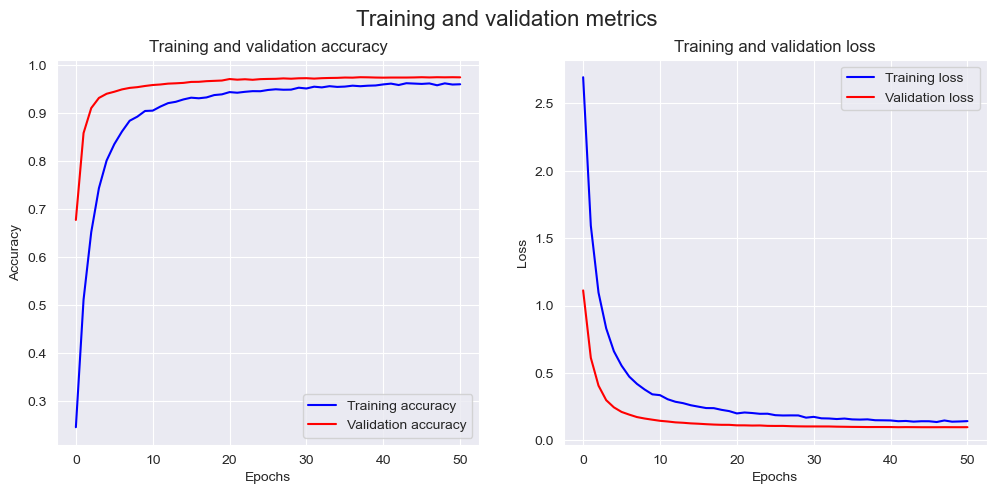

In [16]:
import json
import matplotlib.pyplot as plt

with open('training_history.json', 'r') as f:
    history = json.load(f)

accuracy = history['accuracy']
val_accuracy = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(len(accuracy))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(epochs, accuracy, 'b', label='Training accuracy')
ax1.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(epochs, loss, 'b', label='Training loss')
ax2.plot(epochs, val_loss, 'r', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

fig.suptitle('Training and validation metrics', fontsize=16)
plt.show()

# Making predictions on the Test Data

In [17]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['squirrel', 'dog', 'horse', 'horse', 'cat']


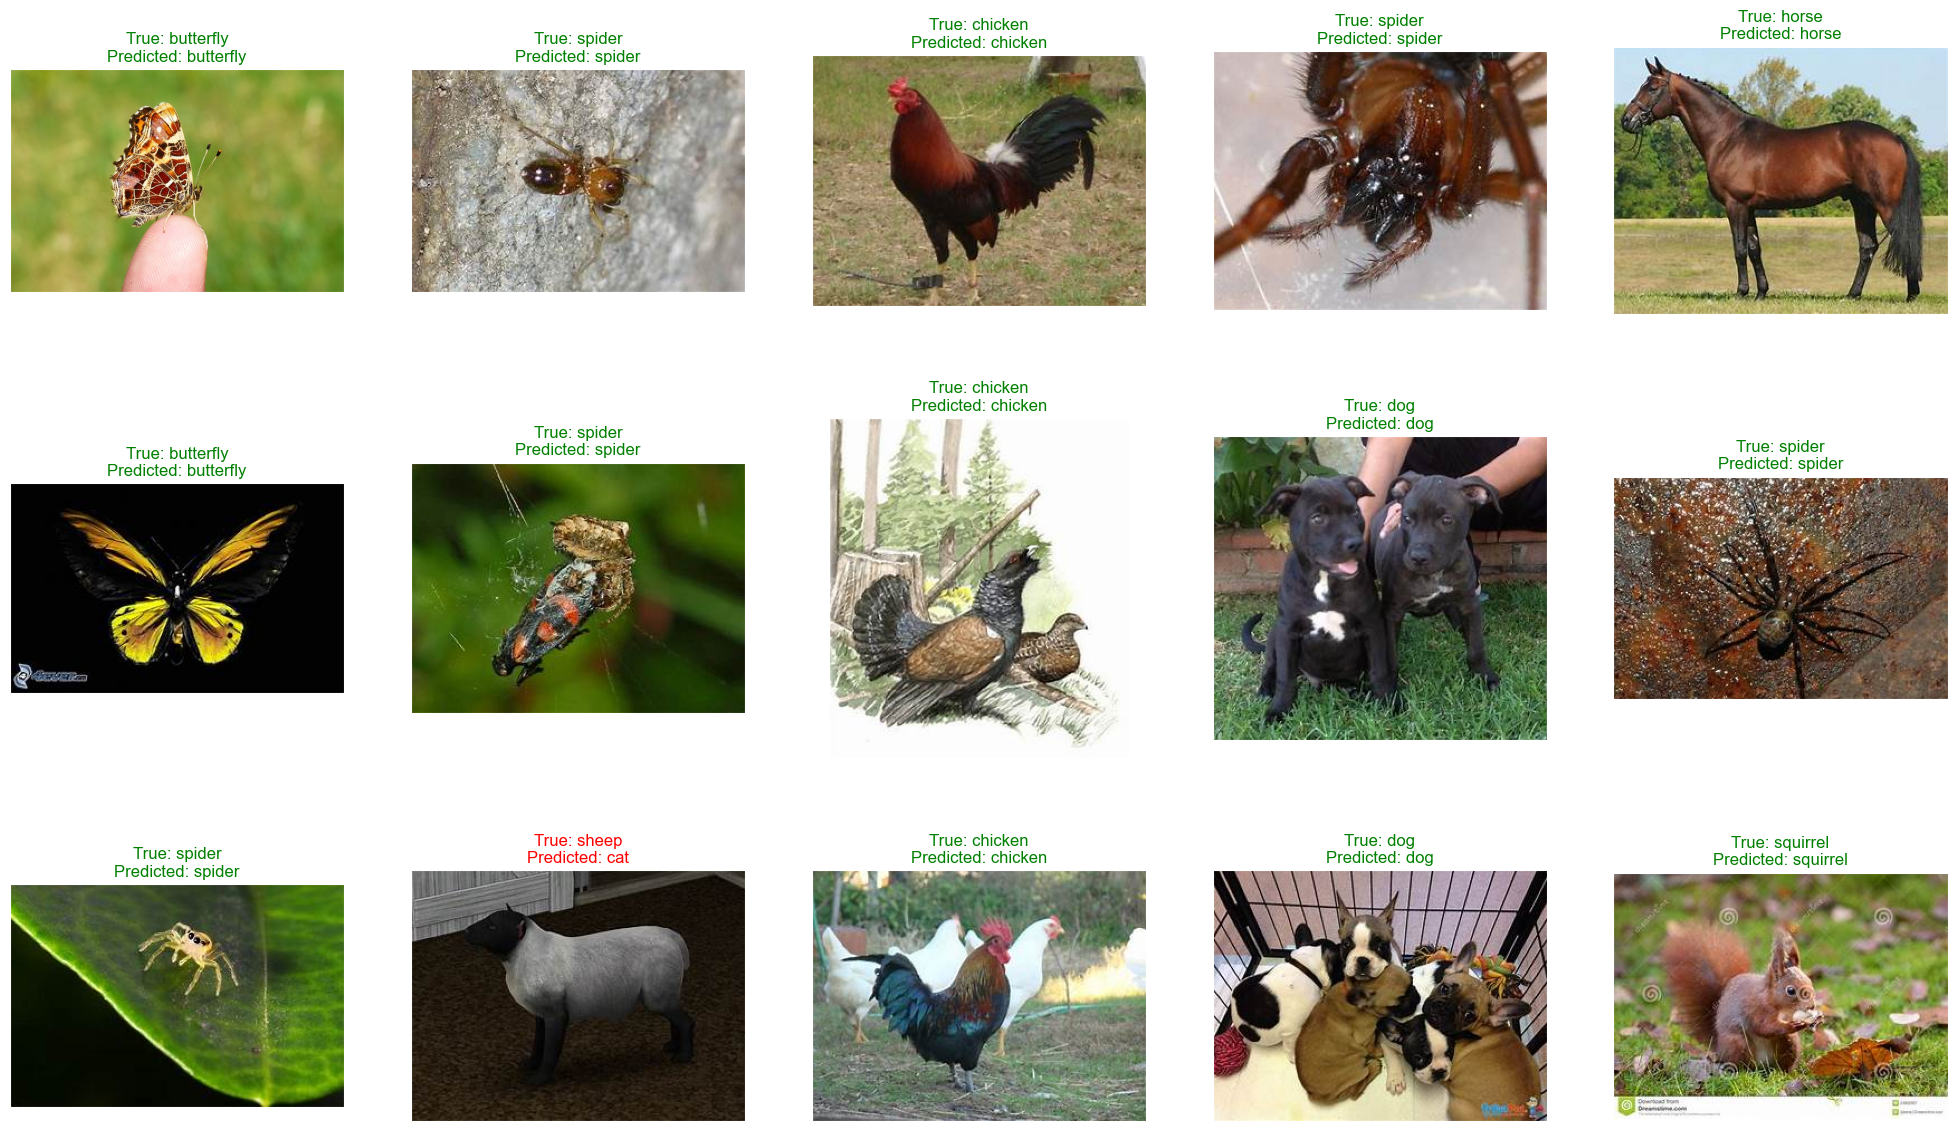

<Figure size 640x480 with 0 Axes>

In [18]:
# Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

# Plotting the Classification Reports and Confusion Matrix

In [19]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

   butterfly       0.97      0.97      0.97       498
         cat       0.97      0.97      0.97       418
     chicken       0.98      0.98      0.98       629
         cow       0.94      0.94      0.94       378
         dog       0.96      0.98      0.97       999
     elefant       0.97      0.98      0.98       355
       horse       0.97      0.95      0.96       483
       sheep       0.96      0.93      0.95       452
      spider       0.98      0.99      0.98      1049
    squirrel       0.99      0.96      0.97       359

    accuracy                           0.97      5620
   macro avg       0.97      0.96      0.97      5620
weighted avg       0.97      0.97      0.97      5620



In [20]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
butterfly,0.973843,0.971888,0.972864,498.000000
cat,0.968825,0.966507,0.967665,418.000000
chicken,0.980831,0.976153,0.978486,629.000000
cow,0.939314,0.941799,0.940555,378.000000
dog,0.962672,0.980981,0.971740,999.000000
elefant,0.974719,0.977465,0.976090,355.000000
horse,0.966245,0.948240,0.957158,483.000000
sheep,0.958998,0.931416,0.945006,452.000000
spider,0.978363,0.991420,0.984848,1049.000000
squirrel,0.985755,0.963788,0.974648,359.000000
